In [18]:
import re
from nltk import word_tokenize
import string
import nltk

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\19178\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\19178\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
def preProcessor(textFile):
    """
    :param textFile:
    :return:
    """
    print('Starting pre-processing of the corpus..')
    print('Start: Word Tokenizing')

    textFilev1 = []
    textFilev1 = [word_tokenize(sent) for sent in textFile]

    print('Stop: Word Tokenizing')
    print('Start: ASCII encoding for special characters')

    textFilev2 = []
    for sent in textFilev1:
        new_sent = []
        for word in sent:
            new_word = word.encode('ascii', 'ignore').decode('utf-8')
            if new_word != '':
                new_sent.append(new_word)
        textFilev2.append(new_sent)

    print('Stop: ASCII encoding for special characters')
    print('Start: Stopwords Removal')

    stop_words_list = stopwords.words('english')

    textFilev1 = []
    for sent in textFilev2:
        new_sent = []
        for word in sent:
            if word.lower() not in stop_words_list:
                new_sent.append(word.lower())
        textFilev1.append(new_sent)

    print('Stop: Stopwords Removal')
    print('Start: Punctuation Removal')

    textFilev2 = []
    for sent in textFilev1:
        new_sent = []
        for word in sent:
            if word not in string.punctuation:
                new_sent.append(word)
        textFilev2.append(new_sent)

    print('Stop: Punctuation Removal')
    return textFilev2

In [20]:
#Reading the news articles file
nyTimesFile = open('C:/Users/19178/Desktop/UMKC/BD/nytimes_news_articles.txt', encoding='latin-1')
nyTimesFile.seek(0)
nyTimesV1 = nyTimesFile.readlines()
nyTimesTemp = []
nyTimesURL = []

for i in range(0, len(nyTimesV1)-1):
    if re.findall('URL', nyTimesV1[i]) == []:
        sent = sent + nyTimesV1[i]
        if (re.findall('URL', nyTimesV1[i+1]) != []) and (i+1 < len(nyTimesV1)):
            nyTimesTemp.append(sent.strip())
    else:
        sent = ''
        nyTimesURL.append(nyTimesV1[i])

nytimes = preProcessor(nyTimesTemp)
result_list=[]
for index, each in enumerate(nytimes):
    category = '/'.join(nyTimesURL[index].split('/')[6:8])
    if '.html' in category:
        category = category.split('/')[0]
    result_list.append({f'{category}': each})
print(len(result_list))

Starting pre-processing of the corpus..
Start: Word Tokenizing
Stop: Word Tokenizing
Start: ASCII encoding for special characters
Stop: ASCII encoding for special characters
Start: Stopwords Removal
Stop: Stopwords Removal
Start: Punctuation Removal
Stop: Punctuation Removal
8893


In [23]:
# create Spark context with Spark configuration
conf = SparkConf().setAppName("nytimes_news_articles")
sc = SparkContext(conf=conf).getOrCreate()


In [24]:
rdd = sc.parallelize(result_list)
wordsRDD = rdd.flatMap(lambda line: (line.values()))
newRDD= wordsRDD.flatMap(lambda l: l)


In [25]:
wordCounts = newRDD.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda a: a[1], ascending=False).collect()[:100]

In [26]:
with open('C:/Users/19178/Desktop/UMKC/BD/top_100_words.txt', 'w') as f:
    f.write('\n'.join([f'{word} - {count}' for word,count in wordCounts]))

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

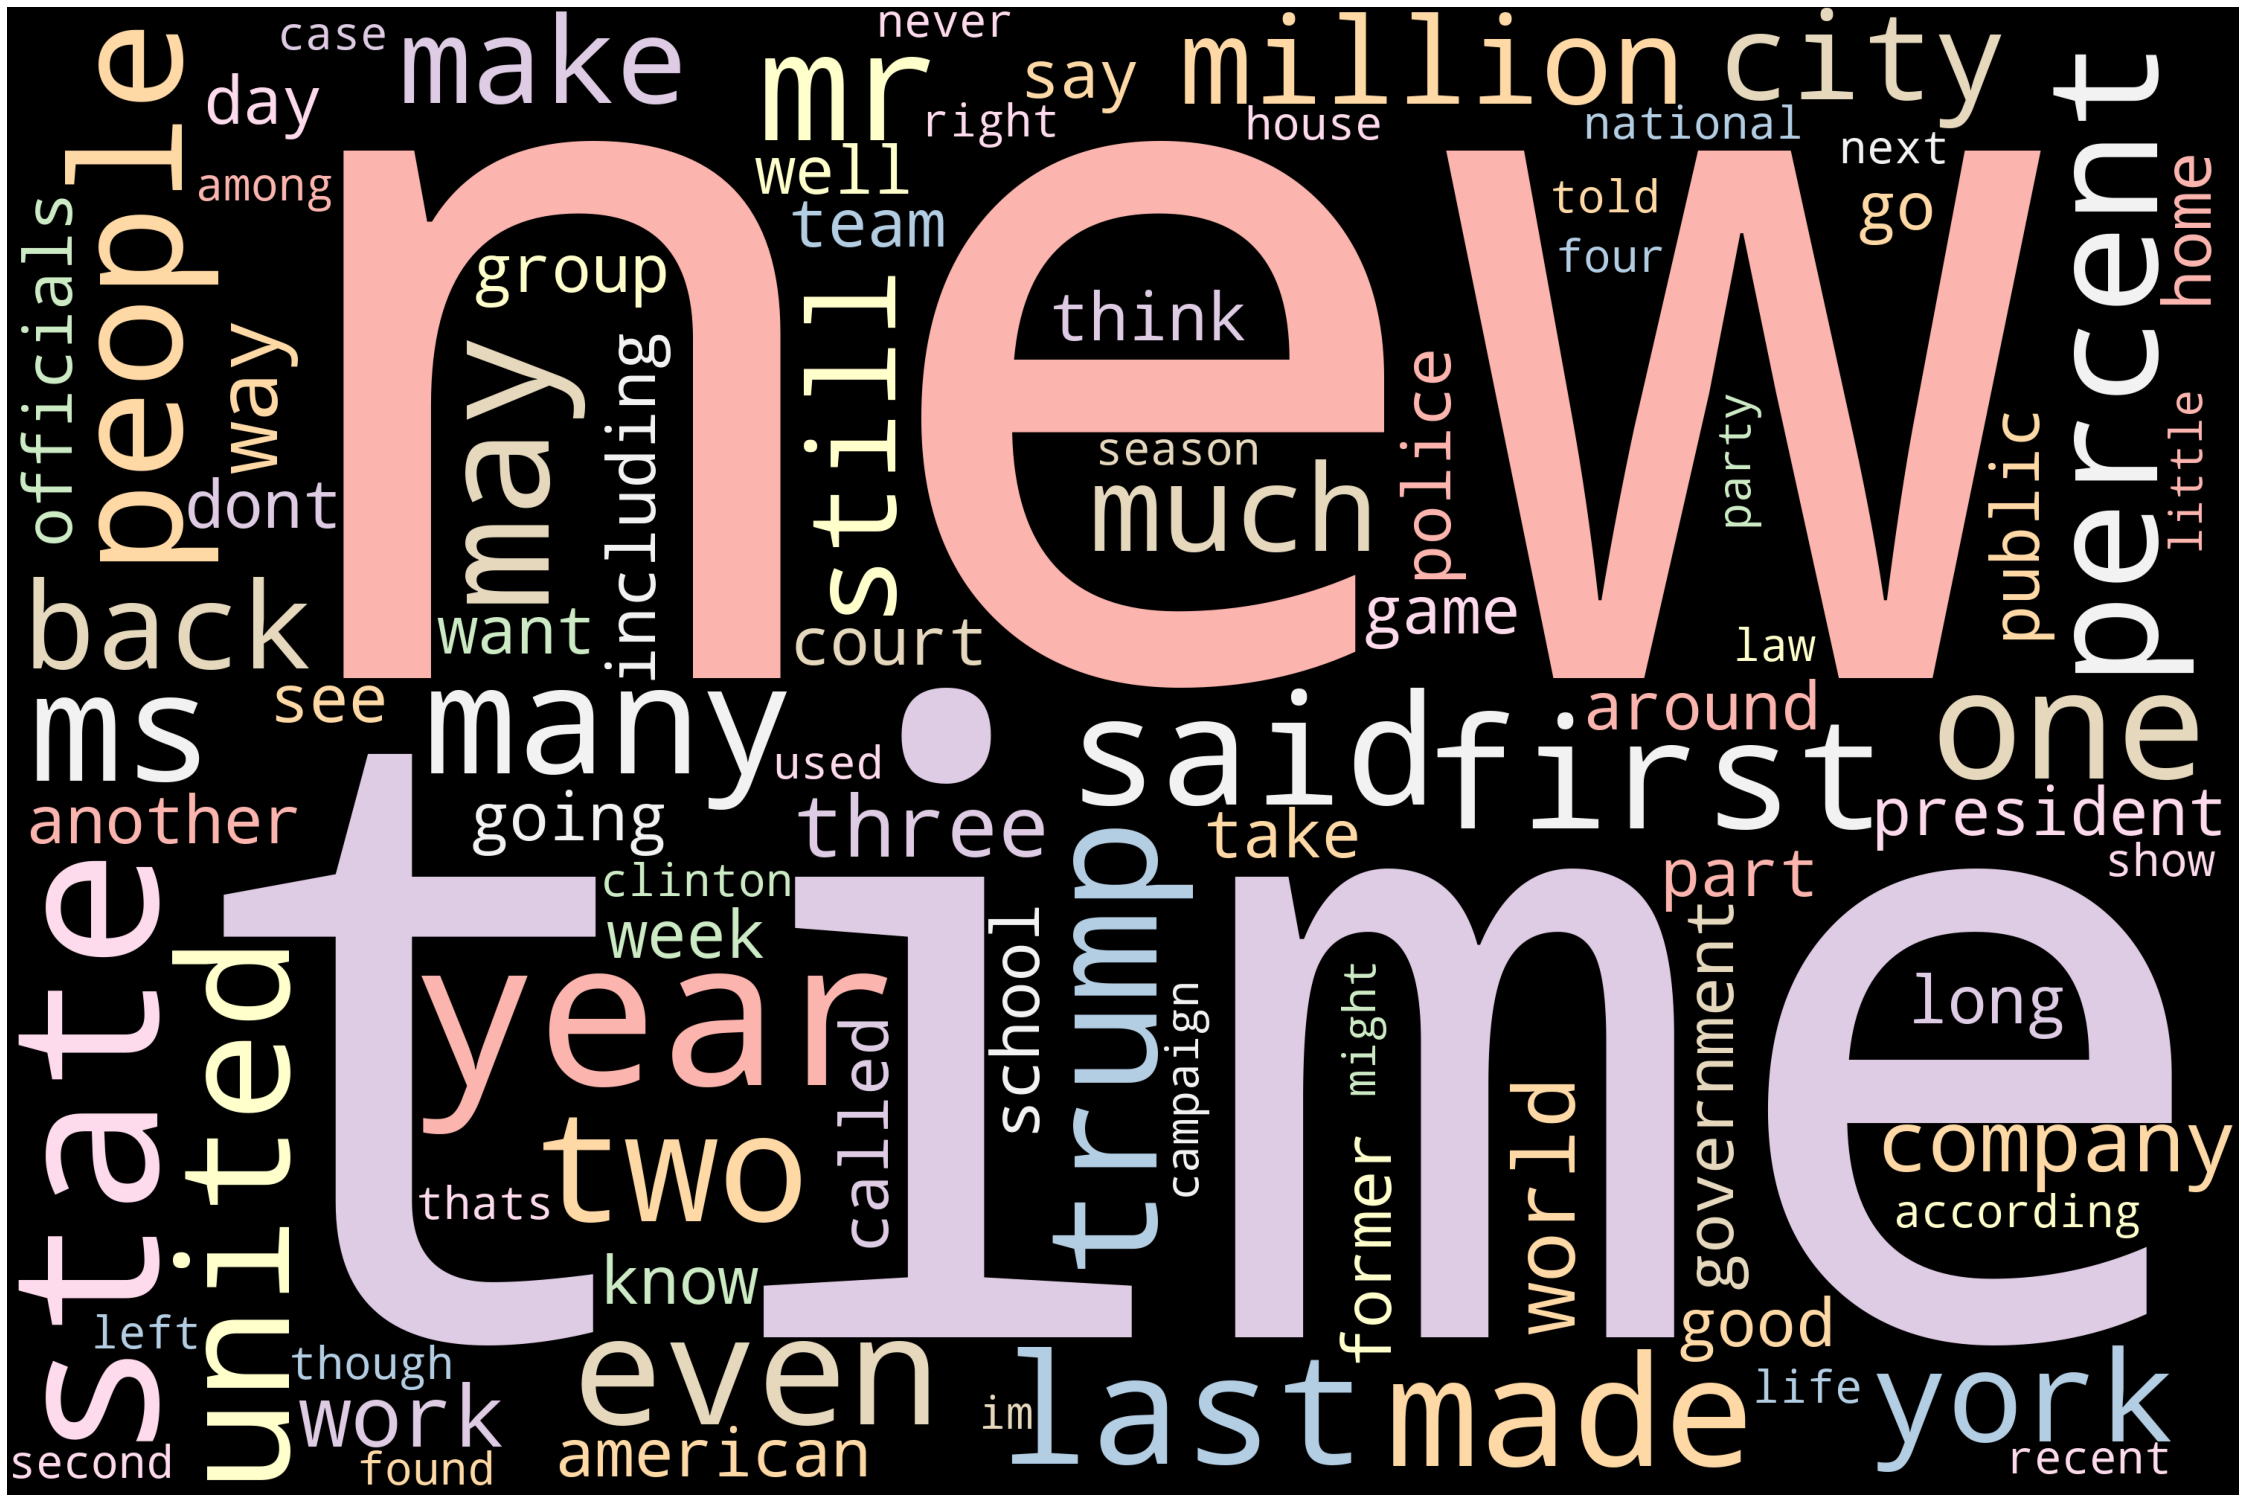

In [28]:

from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
len(wordCounts)
text = ' '.join([word for word, count in wordCounts])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

In [29]:
categoryRDD = rdd.flatMap(lambda line: (line.keys()))

In [30]:
categoryCounts = categoryRDD.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda a: a[1], ascending=False).collect()[:5]

In [31]:
with open('C:/Users/19178/Desktop/UMKC/BD/top_5_categories.txt', 'w') as f:
    f.write('\n'.join([f'{word} - {count}' for word,count in categoryCounts]))

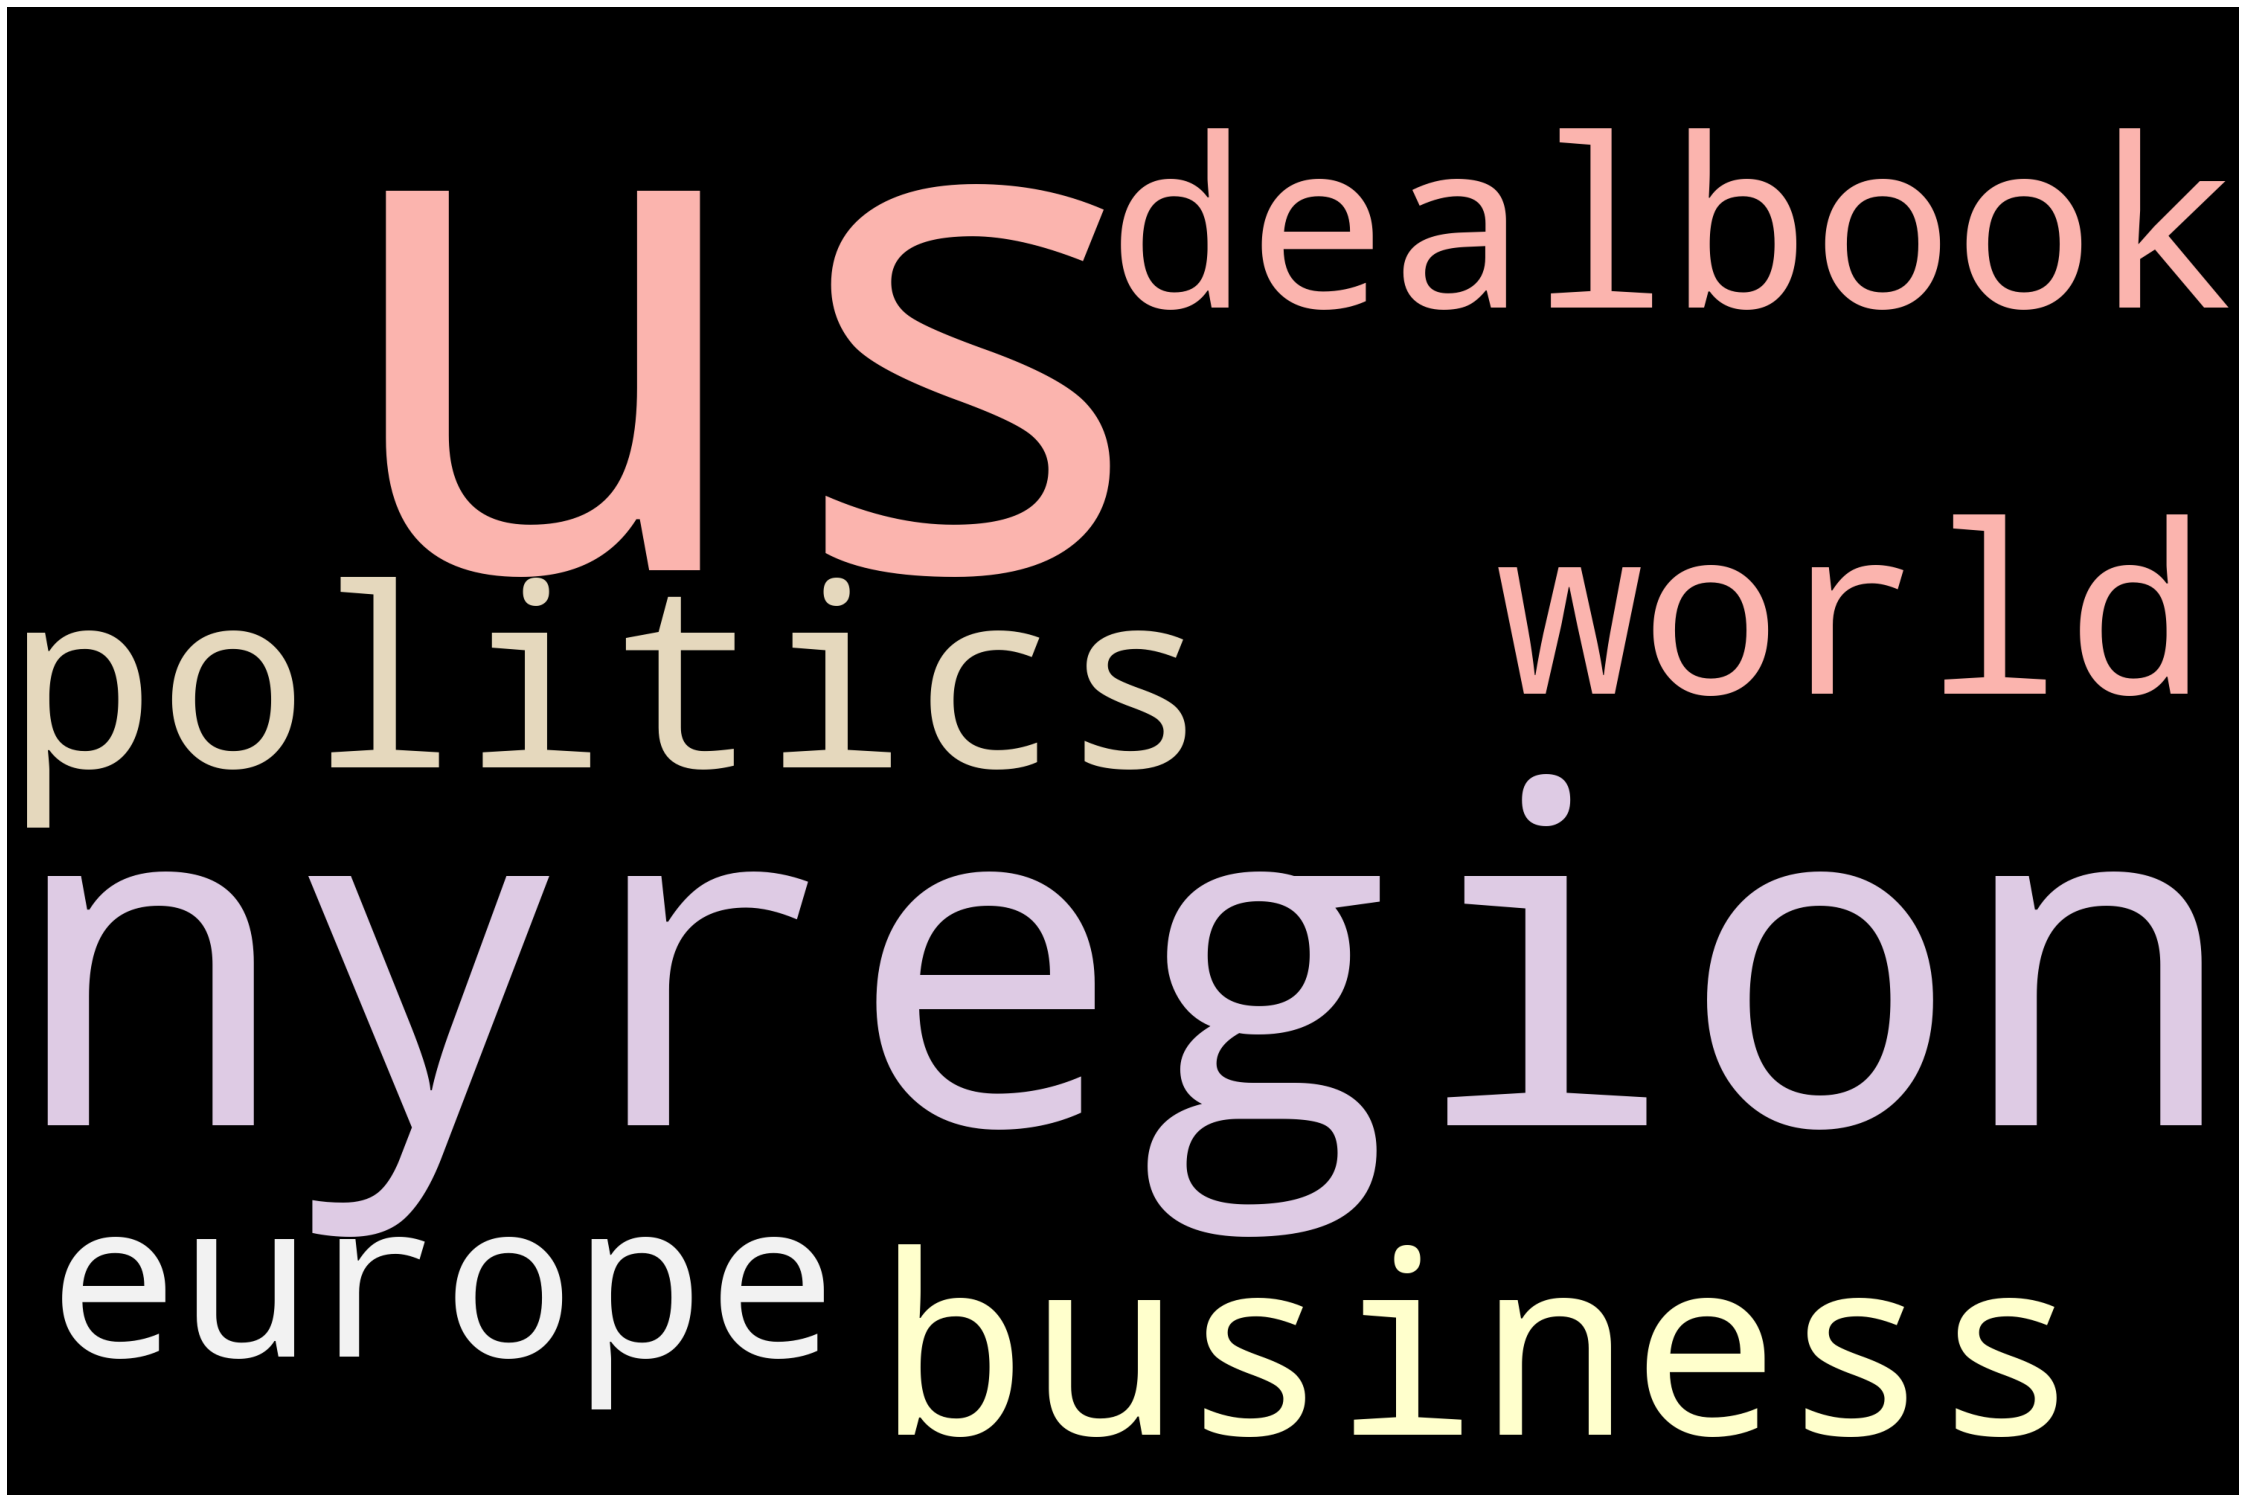

In [32]:
text = ' '.join([category for category, count in categoryCounts])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

In [33]:
top_5_articles = {}
for each in rdd.collect():
    for category,article in each.items():
        if top_5_articles.get(category, None):
            top_5_articles[category] += len(article)
        else:
            top_5_articles[category] = len(article)        
from collections import Counter
top_5_category = list(dict(Counter(top_5_articles).most_common(5)).keys())
top_5_category

['nyregion', 'us/politics', 'us', 'world/europe', 'business']

In [34]:
from operator import add

def get_top_10_by_articles(search_category):
    article_list = []
    for each in rdd.collect():
        for category,articles in each.items():
            if search_category == category:
                article_list.append(set(articles))
    article_rdd = sc.parallelize(article_list)
    article_rdd=article_rdd.flatMap(lambda line: line)
    wordArtCountRDD=article_rdd.map(lambda word: (word, 1)).reduceByKey(add).sortBy(lambda a: a[1], ascending=False) 
    return wordArtCountRDD.collect()[:10]

for each in top5_category: 
    result = get_top_10_by_articles(each)
    for word, count in result:
        print(f'"{word}" appreared in {count} articles under category "{each}"')


"said" appreared in 632 articles under category "nyregion"
"new" appreared in 592 articles under category "nyregion"
"mr." appreared in 559 articles under category "nyregion"
"york" appreared in 511 articles under category "nyregion"
"one" appreared in 505 articles under category "nyregion"
"would" appreared in 468 articles under category "nyregion"
"two" appreared in 446 articles under category "nyregion"
"also" appreared in 435 articles under category "nyregion"
"years" appreared in 427 articles under category "nyregion"
"city" appreared in 395 articles under category "nyregion"
"mr." appreared in 573 articles under category "us/politics"
"said" appreared in 554 articles under category "us/politics"
"would" appreared in 492 articles under category "us/politics"
"republican" appreared in 468 articles under category "us/politics"
"j." appreared in 466 articles under category "us/politics"
"donald" appreared in 442 articles under category "us/politics"
"trump" appreared in 436 articles 

In [22]:
sc.stop()